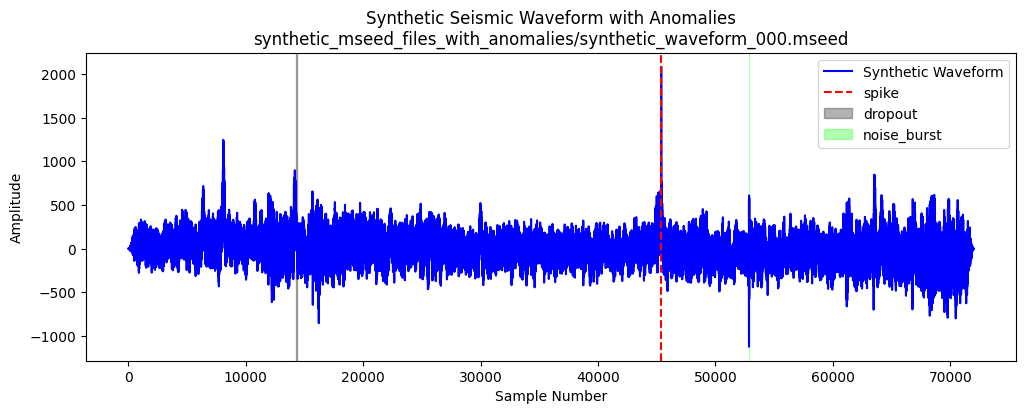

In [49]:
import os
import numpy as np
import random
import obspy
from obspy import read
from obspy.core import UTCDateTime, Stream, Trace
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import median_filter


def add_spike_anomaly(waveform):
    """Adds a sudden sharp spike to one of the most prominent peaks."""
    smoothed_waveform = median_filter(waveform, size=20)  # Reduce small fluctuations
    peaks, properties = find_peaks(waveform, prominence=np.std(waveform) * 3)  # Find strong peaks

    if len(peaks) > 0:
        # Select from the top 3 prominent peaks instead of just the highest
        top_peaks = np.argsort(properties["prominences"])[-3:]  # Get indices of top 3 peaks
        index = peaks[random.choice(top_peaks)]  # Randomly pick one
    else:
        index = random.randint(0, len(waveform) - 1)  # Fallback to random

    waveform[index] += random.uniform(8, 15) * np.std(waveform)  # Large spike
    return index


def add_dropout_anomaly(waveform):
    """Creates a dropout (flatline) ensuring it occurs in a low-energy region."""
    energy_threshold = np.percentile(np.abs(waveform), 30)  # Identify low-energy regions
    low_energy_indices = np.where(np.abs(waveform) < energy_threshold)[0]

    if len(low_energy_indices) > 50:
        start = random.choice(low_energy_indices)
    else:
        start = random.randint(0, len(waveform) // 2)

    duration = random.randint(20, 50)  # Ensure dropout lasts at least 20 samples
    waveform[start:start + duration] = 0
    return start, start + duration


def add_noise_burst_anomaly(waveform):
    """Adds a high-amplitude noise burst in a high-energy segment."""
    high_energy_indices = np.where(np.abs(waveform) > np.std(waveform) * 1.5)[0]

    if len(high_energy_indices) > 50:
        start = random.choice(high_energy_indices)
    else:
        start = random.randint(0, len(waveform) - 100)

    duration = random.randint(10, 50)
    local_energy = np.std(waveform[max(0, start-100):start+100])  # Use local standard deviation
    waveform[start:start + duration] += np.random.normal(0, 3 * local_energy, duration)  # Adaptive noise
    return start, start + duration


def add_frequency_shift_anomaly(waveform, sampling_rate):
    """Applies a frequency shift in a region with significant oscillations."""
    zero_crossings = np.where(np.diff(np.sign(waveform)))[0]

    # Safety check: If not enough zero crossings, fallback to random
    if len(zero_crossings) < 10:
        start = random.randint(0, len(waveform) - 500)
    else:
        diffs = np.diff(zero_crossings)
        median_diff = np.median(diffs) if len(diffs) > 0 else 0  # Ensure median is computable
        
        # Ensure correct indexing by using `[:-1]`
        high_freq_regions = zero_crossings[:-1][diffs < median_diff] if median_diff > 0 else zero_crossings

        if len(high_freq_regions) > 500:
            start = random.choice(high_freq_regions)
        else:
            start = random.randint(0, len(waveform) - 500)

    duration = random.randint(100, 300)
    time = np.linspace(0, duration / sampling_rate, duration)
    
    new_freq = random.uniform(2, 10)  # New frequency shift
    waveform[start:start + duration] *= np.sin(2 * np.pi * new_freq * time)
    return start, start + duration


def create_synthetic_trace(original_trace, waveform):
    """Creates a new ObsPy Trace object with the synthetic waveform."""
    synthetic_trace = Trace(data=waveform)
    synthetic_trace.stats = original_trace.stats.copy()
    synthetic_trace.stats.starttime = UTCDateTime()
    return synthetic_trace


def generate_synthetic_dataset(mseed_files, output_directory, num_samples=100):
    """Generates synthetic waveforms with anomalies and saves them as MSEED files."""
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    labels = []
    
    for i in range(num_samples):
        # Select a random mseed file
        mseed_file = random.choice(mseed_files)
        st = read(mseed_file)
        tr = st[0]
        waveform = tr.data.astype(float).copy()
        sampling_rate = tr.stats.sampling_rate
        
        anomaly_labels = {}
        
        # Add anomalies with improved logic
        if random.random() < 0.4:  # 40% chance to add a spike
            idx = add_spike_anomaly(waveform)
            anomaly_labels['spike'] = idx
        
        if random.random() < 0.4:  # 40% chance to add dropout
            start, end = add_dropout_anomaly(waveform)
            anomaly_labels['dropout'] = (start, end)
        
        if random.random() < 0.5:  # 50% chance to add noise burst
            start, end = add_noise_burst_anomaly(waveform)
            anomaly_labels['noise_burst'] = (start, end)
        
        if random.random() < 0.3:  # 30% chance to add frequency shift
            start, end = add_frequency_shift_anomaly(waveform, sampling_rate)
            anomaly_labels['frequency_shift'] = (start, end)
        
        # Create new trace with synthetic data
        synthetic_trace = create_synthetic_trace(tr, waveform)
        
        # Save synthetic waveform
        synthetic_stream = Stream(traces=[synthetic_trace])
        output_file = os.path.join(output_directory, f"synthetic_waveform_{i:03d}.mseed")
        synthetic_stream.write(output_file, format="MSEED")
        
        # Add filename to labels
        anomaly_labels['filename'] = f"synthetic_waveform_{i:03d}.mseed"
        labels.append(anomaly_labels)
    
    # Save labels
    pd.DataFrame(labels).to_csv(os.path.join(output_directory, "synthetic_anomaly_labels.csv"), index=False)
    
    return labels


def plot_synthetic_waveform(mseed_file, labels):
    """Plots a synthetic waveform with distinct colors for different anomalies."""
    st = read(mseed_file)
    tr = st[0]

    plt.figure(figsize=(12, 4))
    plt.plot(tr.data, label="Synthetic Waveform", color='blue')

    # Define distinct colors for anomalies
    anomaly_colors = {
        "spike": "red",
        "dropout": "black",          # Changed from orange to black for better visibility
        "noise_burst": "lime",       # Changed from green to lime for brightness
        "frequency_shift": "cyan"    # Changed from purple to cyan for clarity
    }

    # Plot anomaly markers with distinct colors
    for anomaly, loc in labels.items():
        if anomaly == 'filename':
            continue
        color = anomaly_colors.get(anomaly, "black")  # Default to black if not in dict
        if isinstance(loc, tuple):
            plt.axvspan(loc[0], loc[1], color=color, alpha=0.3, label=f"{anomaly}")
        else:
            plt.axvline(loc, color=color, linestyle='--', label=f"{anomaly}")

    plt.legend()
    plt.title(f"Synthetic Seismic Waveform with Anomalies\n{mseed_file}")
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude")
    plt.show()


# Example usage
if __name__ == "__main__":
    mseed_directory = r"/Users/subhashreesahoo/Desktop/astronomy/mseed files"
    output_directory = "synthetic_mseed_files_with_anomalies"
    
    mseed_files = [os.path.join(mseed_directory, f) for f in os.listdir(mseed_directory) if f.endswith(".mseed")]
    
    labels = generate_synthetic_dataset(mseed_files, output_directory, num_samples=100)
    
    example_file = os.path.join(output_directory, labels[0]['filename'])
    plot_synthetic_waveform(example_file, labels[0])


In [58]:
import numpy as np
import obspy
from obspy import read
import os
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import kurtosis
import warnings
warnings.filterwarnings('ignore')

class SeismicAnomalyDetector:
    def __init__(self, eps=1.5, min_samples=50):
        self.eps = eps
        self.min_samples = min_samples
        # Define fixed thresholds
        self.amplitude_threshold = 714765.4375
        self.dropout_threshold = 26.3165
        self.noise_threshold = 6773081686748.9385
        self.freq_shift_threshold = 5.8568
        
    def extract_features(self, trace):
        """Extract features for anomaly detection."""
        data = trace.data
        sampling_rate = trace.stats.sampling_rate
        
        # Window the data
        window_size = int(sampling_rate)  # 1-second windows
        n_samples = len(data)
        
        # Ensure we have enough data for at least one window
        if n_samples < window_size:
            raise ValueError(f"Trace too short. Got {n_samples} samples, need at least {window_size}")
        
        # Create windows with overlap
        overlap = window_size // 2
        windows = []
        for i in range(0, n_samples - window_size + 1, overlap):
            windows.append(data[i:i + window_size])
        
        features = []
        for window in windows:
            try:
                # Spike detection features
                max_amplitude = np.max(np.abs(window))
                kurt = kurtosis(window)
                
                # Dropout features
                std = np.std(window)
                zero_crossings = np.sum(np.diff(np.signbit(window)))
                
                # Noise burst features
                energy = np.sum(window**2)
                
                # Frequency shift features
                freqs, psd = signal.welch(window, fs=sampling_rate)
                dominant_freq = freqs[np.argmax(psd)]
                
                features.append([
                    max_amplitude, kurt, std, zero_crossings,
                    energy, dominant_freq
                ])
            except Exception as e:
                print(f"Warning: Error processing window: {e}")
                continue
            
        if not features:
            raise ValueError("No features could be extracted from the trace")
            
        return np.array(features), window_size
    
    def detect_anomalies(self, features):
        """Detect anomalies using DBSCAN."""
        if len(features) == 0:
            return np.array([])
            
        # Standardize features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        labels = dbscan.fit_predict(scaled_features)
        
        return labels
    
    def classify_anomaly_type(self, features, window_idx):
        """Classify the type of anomaly based on features using fixed thresholds."""
        anomaly_types = []
        
        current_features = features[window_idx]
        
        # Check each anomaly type using fixed thresholds
        if current_features[0] > self.amplitude_threshold:
            anomaly_types.append("Spike")
        if current_features[2] < self.dropout_threshold:
            anomaly_types.append("Dropout")
        if current_features[4] > self.noise_threshold:
            anomaly_types.append("Noise-burst")
        if window_idx > 0:
            freq_diff = abs(current_features[5] - features[window_idx-1, 5])
            if freq_diff > self.freq_shift_threshold:
                anomaly_types.append("Frequency-shift")
                
        return anomaly_types
    
    def process_file(self, file_path):
        """Process a single mseed file and detect anomalies."""
        try:
            # Read the waveform
            stream = read(file_path)
            trace = stream[0]
            
            # Extract features
            features, window_size = self.extract_features(trace)
            
            # Detect anomalies
            labels = self.detect_anomalies(features)
            
            # Classify anomaly types
            anomalies = []
            for i in range(len(labels)):
                if labels[i] == -1:  # DBSCAN marks anomalies as -1
                    types = self.classify_anomaly_type(features, i)
                    if types:  # Only include if we can classify the anomaly
                        start_time = i * (window_size // 2)  # Account for overlap
                        end_time = start_time + window_size
                        anomalies.append((start_time, end_time, types))
            
            return trace, anomalies
            
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return None, []
    
    def save_labeled_waveform(self, trace, anomalies, output_path):
        """Save the waveform with anomaly information in the stats."""
        try:
            # Convert anomalies to string representation for storage
            trace.stats.anomalies = str(anomalies)
            
            # Save as mseed
            trace.write(output_path, format="MSEED")
        except Exception as e:
            print(f"Error saving file {output_path}: {e}")
    
    def visualize_waveform(self, trace, anomalies, title="Seismic Waveform with Anomalies"):
        """Visualize a waveform with marked anomalies."""
        plt.figure(figsize=(15, 6))
        time = np.arange(len(trace.data)) / trace.stats.sampling_rate
        
        # Plot the waveform
        plt.plot(time, trace.data, 'b-', label='Waveform', alpha=0.7)
        
        # Plot anomalies
        colors = {'Spike': 'red', 'Dropout': 'green', 
                 'Noise-burst': 'orange', 'Frequency-shift': 'purple'}
        
        # Keep track of legend entries to avoid duplicates
        legend_entries = set()
        
        for start, end, types in anomalies:
            start_time = start / trace.stats.sampling_rate
            end_time = end / trace.stats.sampling_rate
            
            for anomaly_type in types:
                if anomaly_type not in legend_entries:
                    plt.axvspan(start_time, end_time, color=colors[anomaly_type], 
                              alpha=0.3, label=f'{anomaly_type}')
                    legend_entries.add(anomaly_type)
                else:
                    plt.axvspan(start_time, end_time, color=colors[anomaly_type], 
                              alpha=0.3)
        
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

def process_directory(input_dir, output_dir, visualize_count=10):
    """Process all mseed files in a directory."""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize detector
    detector = SeismicAnomalyDetector()
    
    # Get all mseed files
    mseed_files = [f for f in os.listdir(input_dir) if f.endswith('.mseed')]
    
    # Process each file
    for i, file_name in enumerate(mseed_files):
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, f"labeled_{file_name}")
        
        # Process the file
        trace, anomalies = detector.process_file(input_path)
        
        if trace is not None:
            # Save labeled waveform
            detector.save_labeled_waveform(trace, anomalies, output_path)
            
            # Visualize some waveforms
            if i < visualize_count:
                detector.visualize_waveform(trace, anomalies, 
                                         title=f"Waveform {i+1}: {file_name}")
                plt.savefig(os.path.join(output_dir, f"visualization_{i+1}.png"))
                plt.close()

# Usage example
if __name__ == "__main__":
    input_directory = "synthetic_mseed"
    output_directory = "labeled_mseed_with_anomalies"
    process_directory(input_directory, output_directory)

In [54]:
import numpy as np
import pandas as pd
from obspy import read
import os
from scipy import signal
from scipy.stats import kurtosis
from sklearn.metrics import f1_score
import ast
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def extract_features_for_window(data, sampling_rate):
    """Extract features for a single window of data."""
    try:
        # Spike detection features
        max_amplitude = np.max(np.abs(data))
        kurt = kurtosis(data)
        
        # Dropout features
        std = np.std(data)
        zero_crossings = np.sum(np.diff(np.signbit(data)))
        
        # Noise burst features
        energy = np.sum(data**2)
        
        # Frequency shift features
        freqs, psd = signal.welch(data, fs=sampling_rate)
        dominant_freq = freqs[np.argmax(psd)]
        
        return [max_amplitude, kurt, std, zero_crossings, energy, dominant_freq]
    except Exception as e:
        logger.error(f"Error extracting features: {e}")
        return None

def extract_features_with_labels(mseed_file, labels_dict, window_size=100):
    """Extract features and create labels for each window."""
    try:
        # Read the waveform
        stream = read(mseed_file)
        trace = stream[0]
        data = trace.data
        sampling_rate = trace.stats.sampling_rate
        
        # Initialize arrays for features and labels
        features = []
        window_labels = {
            'spike': [],
            'dropout': [],
            'noise_burst': [],
            'frequency_shift': []
        }
        
        # Process each window
        for i in range(0, len(data) - window_size, window_size//2):  # 50% overlap
            window_data = data[i:i+window_size]
            window_features = extract_features_for_window(window_data, sampling_rate)
            
            if window_features is not None:
                features.append(window_features)
                
                # Check each anomaly type
                for anomaly_type in window_labels.keys():
                    if anomaly_type in labels_dict:
                        anomaly_value = labels_dict[anomaly_type]
                        
                        if anomaly_type == 'spike':
                            # For spike, check if the spike location is in this window
                            is_anomaly = (i <= int(anomaly_value) < i+window_size)
                        else:
                            # For other anomalies, check if the window overlaps with anomaly period
                            start, end = map(int, anomaly_value)  # Ensure values are integers
                            is_anomaly = (start < i+window_size and end > i)
                        
                        window_labels[anomaly_type].append(is_anomaly)
                    else:
                        window_labels[anomaly_type].append(False)
        
        # Log the number of positive labels for each anomaly type
        for anomaly_type, labels in window_labels.items():
            positive_count = sum(labels)
            total_count = len(labels)
            logger.info(f"{mseed_file} - {anomaly_type}: {positive_count}/{total_count} positive labels")
        
        return np.array(features), window_labels
    except Exception as e:
        logger.error(f"Error processing file {mseed_file}: {e}")
        return None, None

def find_optimal_thresholds(features_list, labels_list):
    """Find optimal thresholds using grid search."""
    # Combine all features and labels
    all_features = np.vstack(features_list)
    all_labels = {
        'spike': np.concatenate([labels['spike'] for labels in labels_list]),
        'dropout': np.concatenate([labels['dropout'] for labels in labels_list]),
        'noise_burst': np.concatenate([labels['noise_burst'] for labels in labels_list]),
        'frequency_shift': np.concatenate([labels['frequency_shift'] for labels in labels_list])
    }
    
    # Log the total number of positive labels for each anomaly type
    for anomaly_type, labels in all_labels.items():
        positive_count = sum(labels)
        total_count = len(labels)
        logger.info(f"Total {anomaly_type}: {positive_count}/{total_count} positive labels")
    
    best_thresholds = {}
    best_f1_scores = {}
    
    # Spike detection (using amplitude)
    amplitude_percentiles = np.arange(90, 99.1, 0.5)
    best_f1 = 0
    for p in amplitude_percentiles:
        threshold = np.percentile(all_features[:, 0], p)
        predictions = all_features[:, 0] > threshold
        f1 = f1_score(all_labels['spike'], predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_thresholds['amplitude'] = threshold
    best_f1_scores['spike'] = best_f1
    
    # Dropout detection (using STD)
    dropout_percentiles = np.arange(0.1, 10.1, 0.5)
    best_f1 = 0
    for p in dropout_percentiles:
        threshold = np.percentile(all_features[:, 2], p)
        predictions = all_features[:, 2] < threshold
        f1 = f1_score(all_labels['dropout'], predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_thresholds['dropout'] = threshold
    best_f1_scores['dropout'] = best_f1
    
    # Noise burst detection (using energy)
    noise_percentiles = np.arange(90, 99.1, 0.5)
    best_f1 = 0
    for p in noise_percentiles:
        threshold = np.percentile(all_features[:, 4], p)
        predictions = all_features[:, 4] > threshold
        f1 = f1_score(all_labels['noise_burst'], predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_thresholds['noise'] = threshold
    best_f1_scores['noise_burst'] = best_f1
    
    # Frequency shift detection
    freq_shift_multipliers = np.arange(1.1, 5.1, 0.1)
    best_f1 = 0
    baseline_freq = np.median(all_features[:, 5])
    for mult in freq_shift_multipliers:
        threshold = np.std(all_features[:, 5]) * mult
        freq_diffs = np.abs(all_features[:, 5] - baseline_freq)
        predictions = freq_diffs > threshold
        f1 = f1_score(all_labels['frequency_shift'], predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_thresholds['freq_shift'] = threshold
    best_f1_scores['frequency_shift'] = best_f1
    
    return best_thresholds, best_f1_scores

def parse_label_value(value):
    """Parse label values from the CSV file."""
    if pd.isna(value):
        return None
    try:
        if isinstance(value, str):
            if '(' in value or '[' in value:
                return tuple(map(int, ast.literal_eval(value)))
            return float(value)
        return float(value)
    except Exception as e:
        logger.error(f"Error parsing label value {value}: {e}")
        return None

def main():
    # Load synthetic dataset
    synthetic_dir = "synthetic_mseed_files_with_anomalies"
    labels_file = os.path.join(synthetic_dir, "synthetic_anomaly_labels.csv")
    
    # Read labels
    labels_df = pd.read_csv(labels_file)
    logger.info(f"Loaded {len(labels_df)} files from labels CSV")
    
    # Process each file and collect features and labels
    features_list = []
    labels_list = []
    
    for _, row in labels_df.iterrows():
        filename = row['filename']
        file_path = os.path.join(synthetic_dir, filename)
        
        # Create labels dictionary for this file
        labels_dict = {}
        for col in row.index:
            if col != 'filename':
                parsed_value = parse_label_value(row[col])
                if parsed_value is not None:
                    labels_dict[col] = parsed_value
        
        # Extract features and labels
        features, labels = extract_features_with_labels(file_path, labels_dict)
        
        if features is not None and labels is not None:
            features_list.append(features)
            labels_list.append(labels)
    
    logger.info(f"Successfully processed {len(features_list)} files")
    
    if not features_list:
        logger.error("No features were extracted successfully. Please check your data.")
        return
    
    # Find optimal thresholds
    best_thresholds, best_f1_scores = find_optimal_thresholds(features_list, labels_list)
    
    # Print results
    print("\nOptimal Thresholds:")
    for anomaly_type, threshold in best_thresholds.items():
        print(f"{anomaly_type}: {threshold:.4f}")
    
    print("\nF1 Scores:")
    for anomaly_type, score in best_f1_scores.items():
        print(f"{anomaly_type}: {score:.4f}")

if __name__ == "__main__":
    main()

INFO:__main__:Loaded 100 files from labels CSV
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_000.mseed - spike: 2/1438 positive labels
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_000.mseed - dropout: 3/1438 positive labels
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_000.mseed - noise_burst: 2/1438 positive labels
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_000.mseed - frequency_shift: 0/1438 positive labels
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_001.mseed - spike: 0/1438 positive labels
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_001.mseed - dropout: 0/1438 positive labels
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_001.mseed - noise_burst: 0/1438 positive labels
INFO:__main__:synthetic_mseed_files_with_anomalies/synthetic_waveform_001.mseed - frequency_shift: 0/1438 positive labels
INFO:__main__:synthet


Optimal Thresholds:
amplitude: 714765.4375
dropout: 26.3165
noise: 6773081686748.9385
freq_shift: 5.8568

F1 Scores:
spike: 0.0158
dropout: 0.0059
noise_burst: 0.0129
frequency_shift: 0.1694
